## Pennylane - Quantum GANs

In [6]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In this notebook, we will explore quantum GANs to generate hand-written digits of zero. 

In this notebook, we re-create one of the quantum GAN methods called the patch method. This method uses several quantum generators, with each sub-generator, $G^{(i)}$, responsible for constructing a small patch of the final image. The final image is contructed by concatenting all of the patches together as shown below.

![title](GAN_patch.jpeg)

The main advantage of this method is that it is particulary suited to situations where the number of available qubits are limited. The same quantum device can be used for each sub-generator in an iterative fashion, or execution of the generators can be parallelised across multiple devices.

## DATA 

For this example, we will use a [small dataset](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits) of handwritten zeros. First, we need to create a custom dataloader for this dataset.

In [7]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

Next we define some variables and create the dataloader instance.

In [9]:
image_size = 8  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="./optdigits.tra", transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

Let’s visualize some of the data.

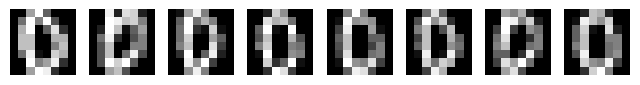

In [10]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

## Implementing the Classical Discriminator

For the discriminator, we use a fully connected neural network with two hidden layers. A single output is sufficient to represent the probability of an input being classified as real.

In [11]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

## Implementing the Quantum Generator

Each sub-generator, $G{(i)}$, shares the same circuit architecture as shown below. The overall quantum generator consists of $N_G$ sub-generators, each consisting of $N$ qubits. The process from latent vector input to image output can be split into four distinct sections: state embedding, parameterisation, non-linear transformation, and post-processing. Each of the following sections below refer to a single iteration of the training process to simplify the discussion. 

![title](qcircuit.jpeg)

###  State Embedding

A latent vector, $z∈R^N$, is sampled from a uniform distribution in the interval $[0,π/2)$. All sub-generators receive the same latent vector which is then embedded using $RY$ gates.

### Parameterised Layers

The parameterised layer consists of parameterised $RY$ gates followed by control Z gates. This layer is repeated $D$ times in total.

### Non-Linear Transform

Quantum gates in the circuit model are unitary which, by definition, linearly transform the quantum state. A linear mapping between the latent and generator distribution would suffice for only the most simple generative tasks, hence we need non-linear transformations. We will use ancillary qubits to help.

For a given sub-generator, the pre-measurement quantum state is given by,

$|Ψ(z)⟩=U_G(θ)|z⟩$

where $U_G(θ)$
represents the overall unitary of the parameterised layers. Let us inspect the state when we take a partial measurment, Π, and trace out the ancillary subsystem, A,

$ρ(z)=\frac{TrA(Π⊗I|Ψ(z)⟩⟨Ψ(z)|)}{Tr(Π⊗I|Ψ(z)⟩⟨Ψ(z)|))}=\frac{TrA(Π⊗I|Ψ(z)⟩⟨Ψ(z)|)}{⟨Ψ(z)|Π⊗I|Ψ(z)⟩}$

The post-measurement state, $ρ(z)$
, is dependent on z in both the numerator and denominator. This means the state has been non-linearly transformed! For this tutorial, $Π=(|0⟩⟨0|)^{⊗N_A}$, where $N_A$

is the number of ancillary qubits in the system.

With the remaining data qubits, we measure the probability of $ρ(z)$ in each computational basis state, $P(j)$, to obtain the sub-generator output, $g(i)$,

$g^{(i)}=[P(0),P(1),...,P(2^{N−N_A}−1)]$

### Post Processing

Due to the normalisation constraint of the measurment, all elements in $g^{(i)}$ must sum to one. This is a problem if we are to use $g^{(i)}$ as the pixel intensity values for our patch. For example, imagine a hypothetical situation where a patch of full intensity pixels was the target. The best patch a sub-generator could produce would be a patch of pixels all at a magnitude of $\frac{1}{2^{N−N_A}}$. To alleviate this constraint, we apply a post-processing technique to each patch,

$x^{(i)}=\frac{g^{(i)}}{max_kg^{(i)}_k}$

Therefore, the final image, $x$, is given by

$x=[x^{(1)},...,x^{(N_G)}]$

In [12]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G

Now we define the quantum device we want to use, along with any available CUDA GPUs (if available).

In [13]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Next, we define the quantum circuit and measurement process described above.

In [14]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

Now we create a quantum generator class to use during training.

In [15]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

## Training

Let’s define learning rates and number of iterations for the training process.

In [16]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

Now putting everything together and executing the training process.

In [17]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise following a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(8,1,image_size,image_size).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break

Iteration: 10, Discriminator Loss: 1.356, Generator Loss: 0.597
Iteration: 20, Discriminator Loss: 1.325, Generator Loss: 0.621
Iteration: 30, Discriminator Loss: 1.333, Generator Loss: 0.615
Iteration: 40, Discriminator Loss: 1.304, Generator Loss: 0.633
Iteration: 50, Discriminator Loss: 1.275, Generator Loss: 0.648
Iteration: 60, Discriminator Loss: 1.222, Generator Loss: 0.670
Iteration: 70, Discriminator Loss: 1.267, Generator Loss: 0.627
Iteration: 80, Discriminator Loss: 1.253, Generator Loss: 0.647
Iteration: 90, Discriminator Loss: 1.256, Generator Loss: 0.624
Iteration: 100, Discriminator Loss: 1.249, Generator Loss: 0.627
Iteration: 110, Discriminator Loss: 1.177, Generator Loss: 0.660
Iteration: 120, Discriminator Loss: 1.175, Generator Loss: 0.633
Iteration: 130, Discriminator Loss: 1.210, Generator Loss: 0.664
Iteration: 140, Discriminator Loss: 1.231, Generator Loss: 0.605
Iteration: 150, Discriminator Loss: 1.252, Generator Loss: 0.606
Iteration: 160, Discriminator Loss

Finally, we plot how the generated images evolved throughout training.

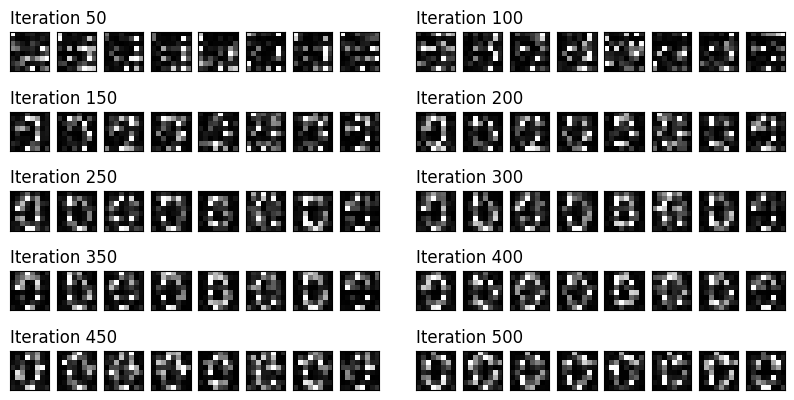

In [18]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()

## References 

[Pennylane - Tutorial Quantum GANs](https://pennylane.ai/qml/demos/tutorial_quantum_gans)